# A feed-forward neural network from scratch

## Helper functions

In [52]:
import numpy as np
import math
import random
from tqdm.notebook import tqdm

from matplotlib import pyplot

def sigmoid(x):
    if isinstance(x, np.ndarray):
        return np.array([sigmoid(_x) for _x in x])
    return 1 / (1 + math.exp(-x))
def sigmoid_prime(x):
    if isinstance(x, np.ndarray):
        return np.array([sigmoid_prime(_x) for _x in x])
    return sigmoid(x)*(1-sigmoid(x))

# add two arrays element-by-element
def add_arrays(a1, a2):
    return [x1 + x2 for x1, x2 in zip(a1, a2)]

# couldn't figure out how to cleanly multiply vectors as matrices...
def transpose_mul_vectors(v1, v2):
    return np.dot(v1.reshape(len(v1), 1), v2.reshape(1, len(v2)))


    

## The Network

In [188]:
class Network:
    def __init__(self, layer_sizes):
        # weights is an array of weight matricies
        self.w = []
        self.b = []
        self.z = []
        self.a = []
        
        self.layer_sizes = layer_sizes
        self.init_parameters()
      
    def init_parameters(self):
        # input layer --w[0]--> first layer --w[1]--> ... --w[n-1]--> n-th layer
        self.w = [np.random.rand(self.layer_sizes[i+1], self.layer_sizes[i]) for i in range(len(self.layer_sizes) - 1)]
        
        # input layer --b[0]--> first layer --b[1]--> ... --b[n-1]--> n-th layer
        self.b = [np.random.rand(layer_size) for layer_size in self.layer_sizes[1:]] 
        
        # input layer --a[0]--> first layer --a[1]--> ... n-th layer --a[n]-->
        self.init_activities()
        
    def init_activities(self, inputs=None):
        self.a = [np.empty(layer_size) for layer_size in self.layer_sizes]
        self.z = [np.empty(layer_size) for layer_size in self.layer_sizes]
        if inputs is not None:
            self.a[0] = inputs
            
    def feed_forward(self, inputs: np.ndarray):
        self.assert_input_shape(inputs)
        self.init_activities(inputs)
        i = 1
        while i < len(self.layer_sizes):
            prev_a = self.a[i-1]
            # sum(weights * previous activations) + bias for each neuron
            self.z[i] = np.dot(self.w[i-1], prev_a) + self.b[i-1]
            
            # pass through activation function
            self.a[i] = self.activation_function(self.z[i])
            
            i += 1
        return self.a[-1]
    
    def gradient(self, examples):
        """ computes the gradient for each individual example using backpropagation and averages them"""
        d_w = [np.zeros(w.shape) for w in self.w]
        d_b = [np.zeros(b.shape) for b in self.b]
        
        for x, y in examples:
            # gradient for a single example
            d_d_w, d_d_b = self.backprop(x, y)
            
            d_w = add_arrays(d_w, d_d_w)
            d_b = add_arrays(d_b, d_d_b)
            
        # average all the gradients from single examples
        d_w = [dw / len(examples) for dw in d_w]
        d_b = [db / len(examples) for db in d_b]
        return d_w, d_b
    
    def train(self, examples, eta):
        d_w, d_b = self.gradient(examples)
        
        self.w = [w - eta * dw for w, dw in zip(self.w, d_w)]
        self.b = [b - eta * db for b, db in zip(self.b, d_b)]
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The "training_data" is a list of tuples
        "(x, y)" representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If "test_data" is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        error_plot = []
        if test_data: n_test = len(test_data)
        n = len(training_data)
        with tqdm(total=epochs * n) as pbar:
            for j in range(epochs):
                random.shuffle(training_data)
                mini_batches = [
                    training_data[k:k+mini_batch_size]
                    for k in range(0, n, mini_batch_size)]
                for mini_batch in mini_batches:
                    self.train(mini_batch, eta)
                    pbar.update(len(mini_batch))
                if test_data:
                    error_plot.append(self.error(test_data))

    #                 print("Epoch {0}: {1}".format(
    #                     j, error_plot[j]))
    #             else:
    #                 print("Epoch {0} complete".format(j))
        return error_plot
                
    def assert_input_shape(self, x):
        assert (x.ndim == 1 and len(x) == self.layer_sizes[0]), "example input ({}) doesn't match network input shape ({})".format(x.shape, self.layer_sizes[0])
    def assert_output_shape(self, y):
        assert (y.ndim == 1 and len(y) == self.layer_sizes[-1]), "example output doesn't match network output shape"
    
    def backprop(self, x, y):
        """ Computes gradient of the cost function.
            Returns d_w, d_b (changes to be made to weights and biases)"""
        d_w = [np.zeros(w.shape) for w in self.w]
        d_b = [np.zeros(b.shape) for b in self.b]

        self.assert_input_shape(x)
        self.assert_output_shape(y)

        output = self.feed_forward(x)

        # compute error for the output layer (which happens to equal the bias gradient)
        error = (self.a[-1] - y) * self.activation_function_prime(self.z[-1])
        d_b[-1] = error
        d_w[-1] = transpose_mul_vectors(error, self.a[-2].transpose())

        # backpropagate the error
        for i, layer in reversed(list(enumerate(self.layer_sizes))[1:-1]):
            curr_w = self.w[i]  # weights connecting previous layer to this one
            error = np.dot(curr_w.transpose(), error) * self.activation_function_prime(self.z[i])

            d_b[i - 1] = error
            prev_a = self.a[i - 1]  # activations of the previous layer)
            d_w[i-1] = transpose_mul_vectors(error, prev_a)

        return d_w, d_b
    
    def example_error(self, example):
        x, t = example
        y = self.feed_forward(x)
        return np.linalg.norm(t - y) ** 2
    
    def network_error(self, examples):
        avg = 0
        for example in examples:
            avg += self.example_error(example)
        return avg / (2 * len(examples))
    
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feed_forward(x)), np.argmax(y))
                        for x, y in test_data]
        return sum(int(t == y) for (y, t) in test_results)
    
    
    def activation_function(self, z):
        return sigmoid(z)
    
    def activation_function_prime(self, z):
        return sigmoid_prime(z)
    
    def error(self, examples):
        e_sum = 0
        for x, t in examples:
            y = self.feed_forward(x)
            e_sum += np.linalg.norm(t - y) ** 2
        return e_sum / (2 * len(examples))
    
    def b_as_matrix(self):
        "Convert biases to matrix form (fill with zeros)"
        max_layer_size = max(self.layer_sizes)
        num_layers = len(self.layer_sizes)
        
        bm = np.empty((num_layers, max_layer_size))
        
        i = 1
        while i < num_layers:
            padded_b = np.zeros(max_layer_size)
            padded_b[:len(self.b[i-1])] = self.b[i-1]
            bm[i] = padded_b
            i += 1
            
        return bm
    
    def random_examples(self, n):
        " Generates n random (input, output) pairs"
        return list(zip(np.random.rand(n, self.layer_sizes[0]), np.random.rand(n, self.layer_sizes[-1])))
    def gradient_check(self, full=False):
        examples = self.random_examples(1000)
        self.init_parameters()
        
        d_w, d_b = self.gradient(examples)
        approximations = []
        
        if full:
            k = 1
            while k < len(self.w):
                wk = self.w[k-1]
                for i in tqdm(range(len(wk))):
                    for j in range(len(wk[i])):
                        d_wk_i_j_approximation = self.gradient_lim_approximation(examples, 0.0001, wk, i, j)
                        approximations.append((d_wk_i_j_approximation, d_w[k-1][i][j]))
                    
                k += 1
        else:
            for n in tqdm(range(500)):
                # pick random layer 
                k = random.randrange(len(self.w))
                wk = self.w[k]
                
                i = random.randrange(len(wk))
                j = random.randrange(len(wk[i]))
                
                d_wk_i_j_approximation = self.gradient_lim_approximation(examples, 0.0001, wk, i, j)
                approximations.append((d_wk_i_j_approximation, d_w[k][i][j]))
                    
                
        return sum([abs(truth - approx) for truth, approx in approximations])
    def gradient_lim_approximation(self, examples, delta, wk, i, j):
        initial_wk_i_j = wk[i][j]

        wk[i][j] -= delta
        err_before = self.error(examples)

        wk[i][j] += 2 * delta
        err_after = self.error(examples)

        d_wk_i_j_approximation = (err_after - err_before) / (2 * delta)
        wk[i][j] = initial_wk_i_j
        
        return d_wk_i_j_approximation

In [189]:
random.randrange(10)

9

In [190]:
mynet = Network([20, 5, 2, 1])
print("created network with layer sizes {}".format(mynet.layer_sizes))

created network with layer sizes [20, 5, 2, 1]


In [191]:
mynet.gradient_check()

  0%|          | 0/500 [00:00<?, ?it/s]

2.14820258290382e-09

## Linear separation
We're going to generate 10000 (x, y) coordinates and label them 0 when they're below y=x and 1 otherwise  

### Generate 10000 training points

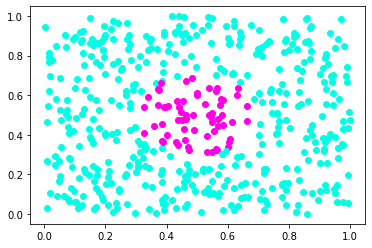

In [129]:
linear_examples = []
for i in range(10000):
    X = np.random.rand(2)
    y = np.array([1, 0]) if math.sqrt((X[1] - 0.5) ** 2 + (X[0] - 0.5) ** 2) < 0.2 else np.array([0, 1])
    if i < 500:
        pyplot.scatter(X[0], X[1], color=(y[0], y[1], 0.9))
    linear_examples.append((X, y))

In [130]:
linet = Network([2, 5, 2])
print("created network with layer sizes {}".format(linet.layer_sizes))

created network with layer sizes [2, 5, 2]


  0%|          | 0/20 [00:00<?, ?it/s]

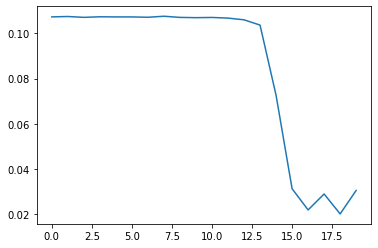

In [131]:
# for i in range(5):
error_plot = linet.SGD(linear_examples[:9000], 20, 10, 4, test_data=linear_examples[:1000])
#     network_paint()
fig = pyplot.figure()
ax = pyplot.axes()

ax.plot(range(len(error_plot)), error_plot)

### Let the network color 500 points

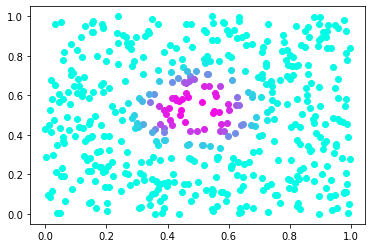

In [132]:
def network_paint():
    for i in range(500):
        X = np.random.rand(2)
        y = linet.feed_forward(X)
        pyplot.scatter(X[0], X[1], color=(y[0], y[1], 0.9))
    pyplot.show()
        
network_paint()

In [133]:
X = np.array([0.0, 0.0])
linet.feed_forward(X)

array([0.00648946, 0.99350729])

## MNIST

### Loading the data

In [107]:
from tensorflow import keras

(raw_train_X, raw_train_y), (raw_test_X, raw_test_y) = keras.datasets.mnist.load_data()
print('X_train: ' + str(raw_train_X.shape))
print('Y_train: ' + str(raw_train_y.shape))
print('X_test:  '  + str(raw_test_X.shape))
print('Y_test:  '  + str(raw_test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


### Plotting the data

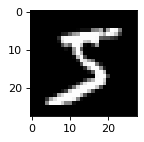

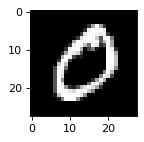

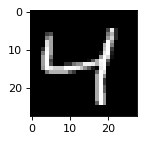

In [134]:
# Plot first images
for i in range(3):  
    pyplot.figure(figsize=(8, 6), dpi=80)
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(raw_train_X[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [135]:
def draw_matrix(m):
    pyplot.figure(figsize=(6, 6), dpi=120)
    pyplot.imshow(m, cmap=pyplot.get_cmap('gray'))
    pyplot.show()

### Prepare the data

In [136]:
# turn number-labels (e.g. 1) into vectors of probabilities (e.g. [0, 1, 0 ... 0])

def vectorize_mnist_output(ys):
    new_ys = np.empty((len(ys), 10))
    for i in range(len(ys)):
        vectorized_y = np.zeros(10)
        vectorized_y[ys[i]] = 1.0
        new_ys[i] = vectorized_y
        
    return new_ys

train_y = vectorize_mnist_output(raw_train_y)

test_y = vectorize_mnist_output(raw_test_y)

_ = [print("{} -> {}".format(raw, vectorized)) for (raw, vectorized) in zip(raw_train_y[:5], train_y[:5])]

5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [137]:
# flatten inputs from 28x28 matrix to 728x1 vector

rtx_shape = raw_train_X.shape
train_X = raw_train_X.reshape(rtx_shape[0], rtx_shape[1] * rtx_shape[2])

test_X = raw_test_X.reshape(raw_test_X.shape[0], raw_test_X.shape[1] * raw_test_X.shape[2])

In [138]:
# compose X and y pairs into tuples
training_examples = list(zip(train_X, train_y))
test_examples = list(zip(test_X, test_y))
print("examples are of form: ({}, {})".format(training_examples[0][0].shape, training_examples[0][1].shape))

examples are of form: ((784,), (10,))


### Creating the network

In [192]:
mynet = Network([784, 30, 10])
print("created network with layer sizes {}".format(mynet.layer_sizes))

created network with layer sizes [784, 30, 10]


In [193]:
initial_error = mynet.error(test_examples)
print("error before training: {}".format(initial_error))

error before training: 4.4999969114866305


### Training the network

In [159]:
raw_

UnicodeDecodeError: 'ascii' codec can't decode byte 0x90 in position 614: ordinal not in range(128)

In [ ]:
error_plot = mynet.SGD(training_examples, 30, 10, 3.0, test_data=test_examples)

fig = pyplot.figure()
ax = pyplot.axes()

ax.plot(range(len(error_plot)), error_plot)

  0%|          | 0/1800000 [00:00<?, ?it/s]

In [158]:
np.round(mynet.feed_forward(test_examples[1][0]), 3)
# test_examples[0][1]

array([0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])

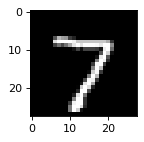

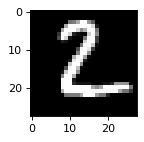

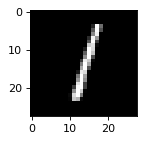

In [164]:
# Plot first images
for i in range(3):  
    pyplot.figure(figsize=(8, 6), dpi=80)
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(test_X[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [194]:
mynet.gradient_check()

  0%|          | 0/500 [00:00<?, ?it/s]

3.082715108445005e-09